In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from utils import *

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.sincos(Noise, Noise_level)
# objective = f_class.Branin(Noise, Noise_level)
# objective = f_class.Keane(Noise, Noise_level)
# objective = f_class.Rosenbrock_2(Noise, Noise_level)  
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Alpine(Noise, Noise_level)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level)
# objective = f_class.quad(Noise, Noise_level)
objective = f_class.Eggholder(Noise, Noise_level)


f = objective.func
clean_f = lambda x: f_class.sincos().func(x)
# clean_f = lambda x: f_class.Branin().func(x)
# clean_f = lambda x: f_class.Keane().func(x)
# clean_f = lambda x: f_class.Rosenbrock_2().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x) 
# clean_f = lambda x: f_class.Schwefel().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Levy().func(x)
# clean_f = lambda x: f_class.quad().func(x)
clean_f = lambda x: f_class.Eggholder().func(x)


B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]
print(f( np.array([1, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-5.  5.]
 [-5.  5.]]
[37.40367091]
dim:  2


In [4]:
x = np.array([1, 1]) 
f(x)

array([37.40367091])

#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [5]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=3000)
# del gp
# (ls, var)

##### Sampling

In [7]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)
    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

    
def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

#### Grid & Plot

In [8]:
# creating meshgrid to plot over entire range
n_Grid = 150
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(22500, 2)

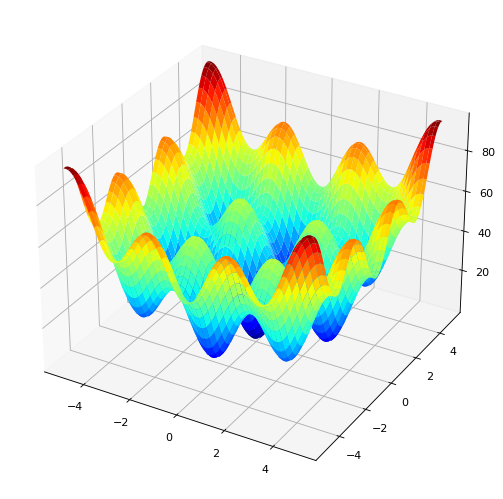

(22500,)

In [9]:
# 3d plot of the test function
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from matplotlib.pyplot import figure
# compute targets
results = f(Grid).reshape(X1.shape)
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, results, cmap='jet')
# show the plot
pyplot.show()
f(Grid).shape

In [10]:
# 3d plot of the gradient
# approximate the gradient
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
approx_grad.shape
g1 = approx_grad[:, 0]
g2 = approx_grad[:, 1]
g1, g2

(array([ 3.60052776,  0.80519009, -2.18212223, ...,  2.18212128,
        -0.80519009, -3.60052872]),
 array([ 3.60052776,  3.60052776,  3.60052776, ..., -3.60052872,
        -3.60052776, -3.60052872]))

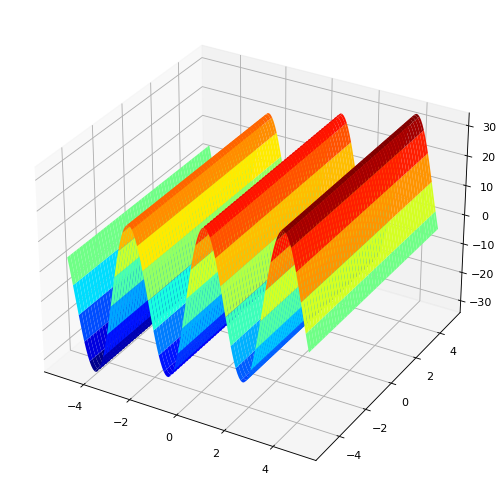

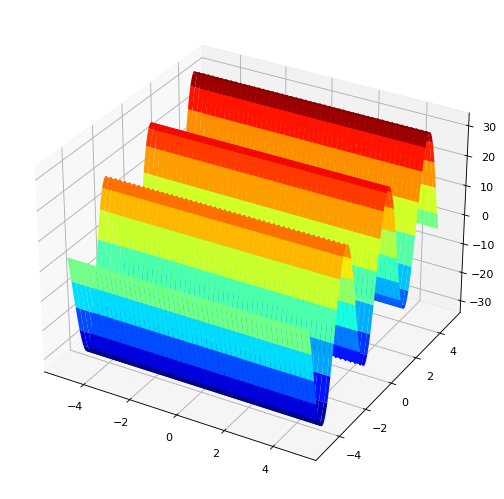

In [11]:
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g1.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g2.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# *BO Test*

In [12]:
MAX = 200 # function observations

## GD

#### Set up

In [13]:
# # initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
# w = X[np.argmin(f(X))].reshape(1, dim)

# # sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)
# X_fix = X

In [14]:
gp = GP_grad(B, Noise, Noise_level, compress=False)
# gp.set_hyper(ls, var) # if online, skip

gp.set_data(X, f(X))

ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

history_w = []
history_full_w = []
history_f = []

##### warm up with UCB

In [15]:
warmup = 3
history_warmup = []
for i in range(1, warmup+1):
    b = np.log(i)
    w, fw = gp.ucb_minimize(b)
    X = np.vstack([X, w])
    
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    gp.add_data(w.reshape(1, dim), f(w))
    
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [-4.30515496  4.8943869 ], f(w):  87.74859673492624, 
2, w:  [4.95408766 4.30825787], f(w):  87.80628305773863, 
3, w:  [-5.         -1.47266867], f(w):  74.91719284208102, 


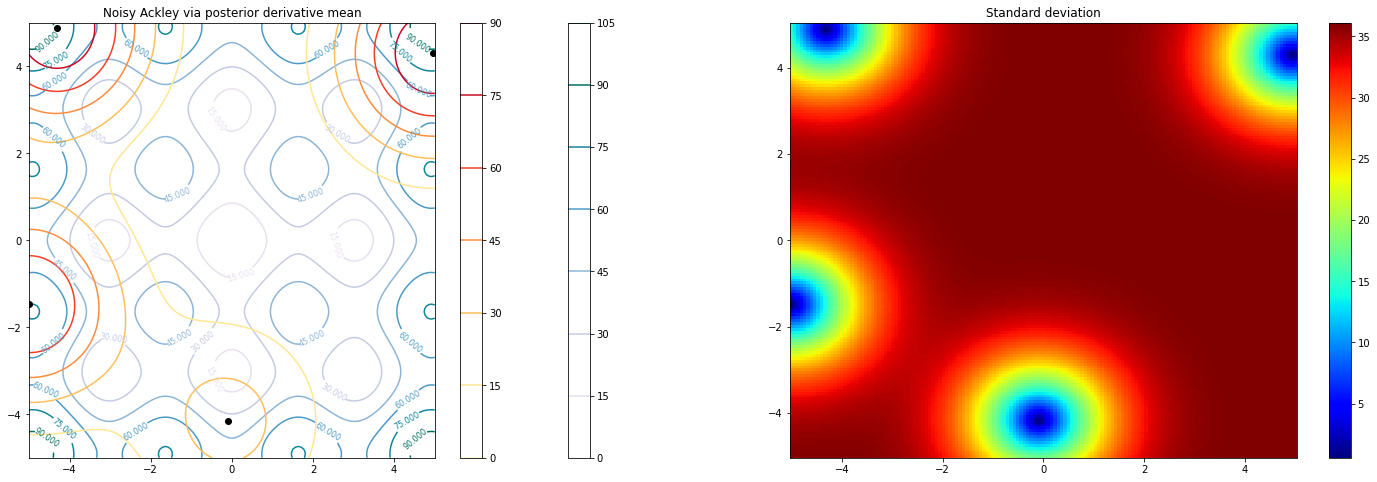

In [16]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
x = Grid[:,0]
y = Grid[:,1]

# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

<ipython-input-17-6c58d6ef8c4d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history_warmup)[:, 1]), "-^")


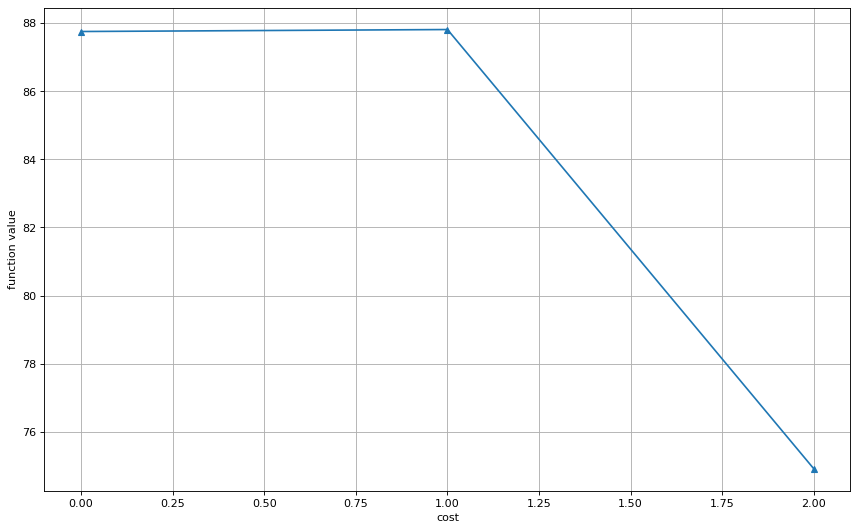

In [17]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history_warmup)[:, 1]), "-^")
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

##### optimize with GD

In [18]:
w, _ = gp.ucb_minimize(1) 
optimizer = GD(gp, B, w, f)

In [19]:
gp.posterior(w), f(w)
# gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

((array([[0.19259964]]), array([[1303.74140584]])), array([70.69732688]))

In [20]:
m, v = gp.posterior_full_grad('full', dim*[w])
m, v

(array([[-0.27247825],
        [ 0.0004424 ]]),
 array([[ 4.76269690e+02, -3.12748729e-02],
        [-3.12748729e-02,  4.76333547e+02]]))

In [21]:
optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

array([-3.60052872, 17.99105835])

In [22]:
gp.optimize()
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup
desc = -optimizer._grad()
lr_const = 0.1
lr = lr_const
while cost <= MAX:
    # update w 
    lr = lr_const
    if optimizer.contFail >= 10 or stall:
        print()
        print('New Local Search---------- ',)
        print('Fail = ', optimizer.contFail, end = ', ')
        print('Norm = ', LA.norm(desc))
        
        # random draw
#         w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))

        # UCB draw
        w, _ = gp.ucb_minimize(cost)
        
        if is_new(w, gp.X) == False:
            raise ValueError('  ?? hit past points')
        
        gp.add_data(w.reshape(1, -1), f(w))
        
        # change back setting
        stall = False
        history_w.append(optimizer.history_w)
        history_f.append([f(w).item() for w in optimizer.history_w])
        optimizer = GD(gp, B, w, f)
    else:
        lr = lr*1
        w, desc = optimizer.update_sample(y_best=np.min(f(gp.X)), lr=lr)
    
        if is_new(w, gp.X) == False:
            print('  ** hit past points')
            stall = True
            continue
            
        gp.add_data(w.reshape(1, -1), f(w))
    
    cost += 1
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('     d(w): ', np.squeeze(m), end = ', ')
    print('    s.d: ', np.squeeze(v), end = ', ')
    print('    g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print()
        
print('Max Cost reached = ', cost)
history_w.append(optimizer.history_w)
history_f.append([f(w).item() for w in optimizer.history_w])

GD loop:  0
5.     w:  [ 5.     -2.2185],     f(w): 68.809004 
     d(w):  [4.4858 8.0213],     s.d:  [2.6112 2.5557],     g(w): [-3.6005 19.6211]

GD loop:  0
  # Optimal (ls, var) =  (7.824968220820974, 13649.424644871047)
6.     w:  [ 4.9983 -2.3185],     f(w): 66.811514 
     d(w):  [-2.6762 20.2133],     s.d:  [6.1712 0.1302],     g(w): [-3.5325 20.292 ]

GD loop:  0
7.     w:  [ 4.9975 -2.4185],     f(w): 64.793018 
     d(w):  [ 1.2616 20.2791],     s.d:  [5.298  0.0177],     g(w): [-3.5003 19.9692]

GD loop:  0
8.     w:  [ 4.9665 -2.5136],     f(w): 63.034830 
     d(w):  [-5.6983 20.4444],     s.d:  [0.0229 0.035 ],     g(w): [-2.2317 18.7449]

GD loop:  6
  # Optimal (ls, var) =  (1.6532529115059222, 10009.272010075212)
9.     w:  [ 5.     -3.1914],     f(w): 58.235101 
     d(w):  [-0.6328 -9.141 ],     s.d:  [23.8481  1.7636],     g(w): [-3.6005 -8.8673]

GD loop:  0
10.     w:  [ 4.9011 -3.1769],     f(w): 58.264484 
     d(w):  [-0.5837 -8.2903],     s.d:  [2.5581 1.7449

  # Optimal (ls, var) =  (1.7001612006717386, 13295.821209753134)
54.     w:  [8.4938e-05 4.2604e+00],     f(w): 38.381784 
     d(w):  [ 0.1553 28.1686],     s.d:  [0.615  0.0167],     g(w): [4.4174e-03 2.8166e+01]

GD loop:  0
55.     w:  [1.9585e-04 4.1604e+00],     f(w): 35.434157 
     d(w):  [ 0.2381 30.6415],     s.d:  [0.5552 0.0093],     g(w): [1.0184e-02 3.0646e+01]

GD loop:  0
56.     w:  [5.5968e-04 4.0604e+00],     f(w): 32.282291 
     d(w):  [-6.8010e-03  3.2236e+01],     s.d:  [0.4727 0.004 ],     g(w): [2.9104e-02 3.2236e+01]

GD loop:  0
  # Optimal (ls, var) =  (1.8810895838288841, 95707.45390035346)
57.     w:  [5.6524e-04 3.9604e+00],     f(w): 29.019016 
     d(w):  [ 0.0653 32.8637],     s.d:  [0.9439 0.0043],     g(w): [2.9393e-02 3.2865e+01]

GD loop:  0
58.     w:  [1.1460e-03 3.8604e+00],     f(w): 25.742559 
     d(w):  [-0.1756 32.4964],     s.d:  [1.0278 0.0095],     g(w): [ 0.0596 32.4993]

GD loop:  0
59.     w:  [1.7498e-03 3.7604e+00],     f(w): 22.55

GD loop:  6
  # Optimal (ls, var) =  (1.8740472040386906, 12476.661555435307)
102.     w:  [-3.049  -2.9784],     f(w): 19.040962 
     d(w):  [-1.475   2.0446],     s.d:  [0.0365 0.0301],     g(w): [-1.4957  2.0596]


New Local Search---------- 
Fail =  10, Norm =  2.4762469129700206
103.     w:  [-5.      1.8824],     f(w): 74.181942 
     d(w):  [-9.2018 21.0447],     s.d:  [54.0356 44.6014],     g(w): [  3.6005 -10.8263]

GD loop:  0
104.     w:  [-4.9003  1.8749],     f(w): 74.414337 
     d(w):  [ 2.6456 20.3008],     s.d:  [ 3.7933 44.0106],     g(w): [ -0.6254 -10.5345]

GD loop:  0
  # Optimal (ls, var) =  (1.9345958240398928, 12551.52723018019)
105.     w:  [-4.909   1.7753],     f(w): 75.265123 
     d(w):  [-0.0166 -8.6364],     s.d:  [2.9255 1.1606],     g(w): [-0.2375 -6.3905]

GD loop:  1
106.     w:  [-4.9677  1.9639],     f(w): 73.272307 
     d(w):  [  3.6305 -12.8623],     s.d:  [1.8965 0.74  ],     g(w): [  2.2807 -13.764 ]

GD loop:  0
107.     w:  [-4.9801  2.0631

/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


GD loop:  6
124.     w:  [-5.      3.0196],     f(w): 57.476591 
     d(w):  [ 5.2706e+00 -1.9818e-03],     s.d:  [1.2045 0.0023],     g(w): [3.6005e+00 2.2840e-04]

GD loop:  6
125.     w:  [-5.      3.0197],     f(w): 57.476592 
     d(w):  [5.2708e+00 2.4012e-03],     s.d:  [1.2048 0.0023],     g(w): [3.6005 0.0046]


New Local Search---------- 
Fail =  10, Norm =  3.7058283046539584
  # Optimal (ls, var) =  (1.6106164925009092, 71232.4265222349)
126.     w:  [5.     2.3458],     f(w): 66.251231 
     d(w):  [-0.4822 30.4194],     s.d:  [160.7191 102.5451],     g(w): [ -3.6005 -20.303 ]

GD loop:  0
127.     w:  [4.9011 2.3308],     f(w): 66.708772 
     d(w):  [-8.0685 29.2051],     s.d:  [ 16.7946 102.2716],     g(w): [  0.5876 -20.3061]

GD loop:  0
128.     w:  [4.9151 2.2318],     f(w): 68.704635 
     d(w):  [ -1.6831 -20.0272],     s.d:  [12.0295  3.4272],     g(w): [ -0.0299 -19.7662]

GD loop:  0
  # Optimal (ls, var) =  (1.9490805889826042, 84175.35119005346)
129.     w:  

GD loop:  0
  # Optimal (ls, var) =  (1.548898345237278, 7426.641344942531)
171.     w:  [-2.9096  0.0278],     f(w): 9.807523 
     d(w):  [5.3597 1.4452],     s.d:  [0.0322 0.0977],     g(w): [5.37   1.4435]

GD loop:  6
172.     w:  [-2.9845 -0.0551],     f(w): 9.597906 
     d(w):  [ 1.7713 -2.8637],     s.d:  [0.0953 0.1792],     g(w): [ 1.7553 -2.8591]

GD loop:  6
173.     w:  [-3.0372  0.0289],     f(w): 9.517780 
     d(w):  [-0.892   1.5379],     s.d:  [0.0183 0.2457],     g(w): [-0.8943  1.502 ]

GD loop:  6
  # Optimal (ls, var) =  (1.8591165172571278, 45695.746942270554)
174.     w:  [-3.0217 -0.0659],     f(w): 9.601023 
     d(w):  [-0.0981 -3.4382],     s.d:  [0.0182 0.0588],     g(w): [-0.1037 -3.4167]

GD loop:  6
175.     w:  [-3.0196  0.0341],     f(w): 9.518412 
     d(w):  [-5.1874e-04  1.7740e+00],     s.d:  [0.0024 0.0224],     g(w): [-8.2338e-04  1.7717e+00]

GD loop:  6
176.     w:  [-3.0203 -0.0659],     f(w): 9.600962 
     d(w):  [-0.0389 -3.4154],     s.d:

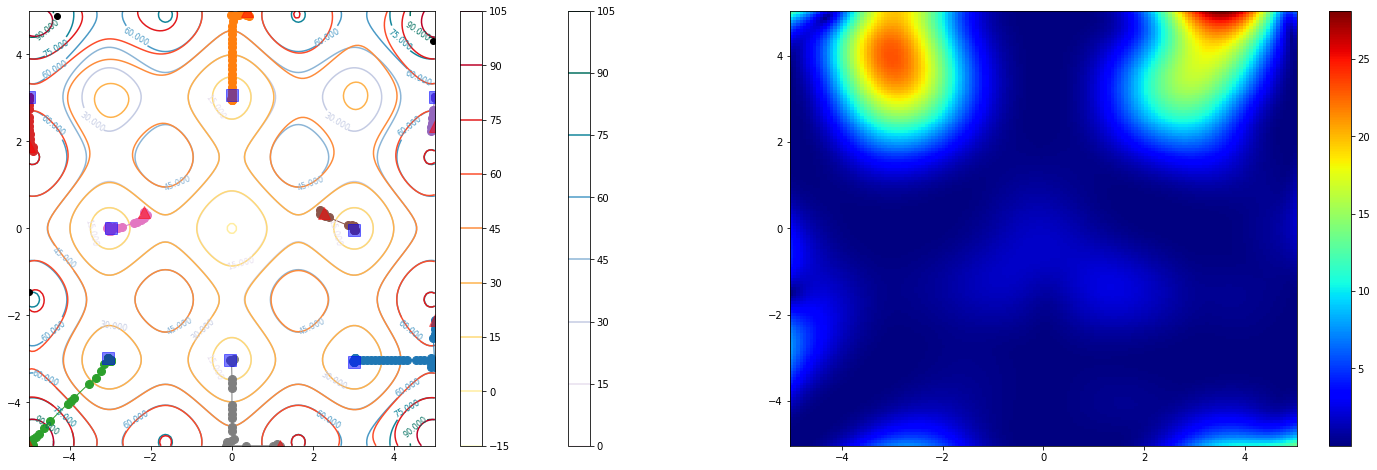

In [23]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
x = Grid[:,0]
y = Grid[:,1]

# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

for lw in history_w:
    array_w = np.vstack(lw)
    ax1.plot(array_w[:, 0], array_w[:, 1], 'o-', linewidth=1, markersize=8)
    ax1.plot(array_w[0][0], array_w[0][1], "r^", markersize=12, alpha=0.5)
    ax1.plot(array_w[-1][0], array_w[-1][1], "bs", markersize=12, alpha=0.5)


UCBwarmup = np.vstack([point[0] for point in history_warmup])
ax1.plot(UCBwarmup[:, 0], UCBwarmup[:, 1], 'ko', linewidth=2)
# ax1.title.set_text("Noisy Ackley via posterior derivative mean")
# ax2.title.set_text("Standard deviation")

# plot derivative
#     p1 = y*np.cos(y)* ( (2*x*np.cos(x)) - np.sin(x) ) / (2* (x*y)**(3/2))
#     p2 = - x*np.sin(x)* ( (2*y*np.sin(y)) + np.cos(y) ) / (2* (x*y)**(3/2))
#     p1 = np.cos(x)*np.cos(y)
#     p2 = -np.sin(x)*np.sin(y)

#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, p1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, p2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")
# Saving all the plots in 2D_Plots (need to creat a folder) 
pl.show()

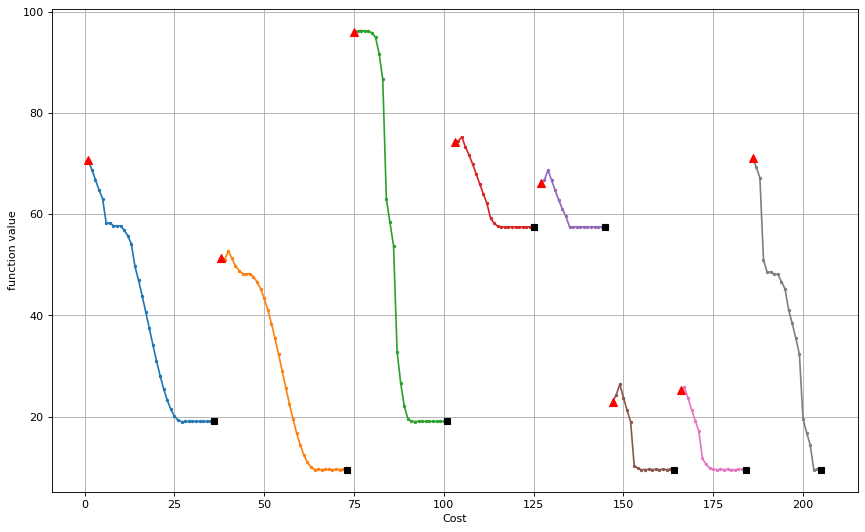

In [24]:
pl.figure(figsize=(13, 8), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=2)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + setup # COST includes setup

pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [25]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([-3.0206, -0.0053]), 9.488961701173015, 177)

In [26]:
gp.get_hyper()

{'var': 36119.888615143915, 'lengthscale': 1.7998301021885035}

In [27]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *UCB*

In [28]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = []

In [29]:
mesh = np.random.uniform(gp.B[:, 0], gp.B[:, 1], size=(1000, gp._B.shape[0]))
mesh[0].shape

(2,)

In [30]:
cost = setup + warmup
while cost < MAX:
    # posterior of GP given gp.X, gp.y
#     mu, covar = gp.posterior(Grid)
#     mu = np.squeeze(mu)
#     s = np.sqrt(np.diag(covar))
    
    # posterior of GP derivative given gp.X, gp.y
    # partial x1
#     gp.set_p(0)
#     mu_grad_1, covar_grad_1 = gp.posterior_grad(Grid)
#     mu_grad_1 = np.squeeze(mu_grad_1)
#     s_grad_1 = np.sqrt(np.diag(covar_grad_1))

#     # partial x2
#     gp.set_p(1)
#     mu_grad_2, covar_grad_2 = gp.posterior_grad(Grid)
#     mu_grad_2 = np.squeeze(mu_grad_2)
#     s_grad_2 = np.sqrt(np.diag(covar_grad_2))
    
    # 1. Thompson Sampling
#     L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid**dim)) # LL^T = Sigma (posterior covariance)
#     f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid**dim, 1)))
#     arg_min = np.argmin(f_post)
#     w = Grid[arg_min]
    
    # 2. GP_UCB
    b = np.log(cost)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
    w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 4 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

4, w:  [ 5. -5.], f(w):  95.97678822691131, 
  # Optimal (ls, var) =  (6.157685990354438, 6456.200382629537)
5, w:  [-4.2586 -5.    ], f(w):  86.32034092561508, 
6, w:  [ 0.2327 -0.4123], f(w):  5.567195265983742, 
7, w:  [ 1.2081 -0.9005], f(w):  39.47506315402646, 
8, w:  [-0.5545  3.1554], f(w):  17.199876694493323, 
  # Optimal (ls, var) =  (3.7696244033594573, 6360.742100256433)
9, w:  [-1.8083  0.6996], f(w):  37.74096728570555, 
10, w:  [1.0385 5.    ], f(w):  67.62720653757931, 
11, w:  [0.7442 1.7703], f(w):  39.17785310275114, 
12, w:  [-0.9846 -2.013 ], f(w):  42.79189977180841, 
  # Optimal (ls, var) =  (2.3182203456009867, 4973.1988512713915)
13, w:  [-1.4215  5.    ], f(w):  74.45567616770836, 
14, w:  [ 5.     -0.2219], f(w):  49.24814292384594, 
15, w:  [ 1.5739 -5.    ], f(w):  75.4652701196641, 
16, w:  [-5.      1.9463], f(w):  73.41461074073098, 
  # Optimal (ls, var) =  (2.7390948369075567, 14411.495758206585)
17, w:  [ 5.     -2.2205], f(w):  68.77012499314104, 
1

119, w:  [-3.9939 -0.6386], f(w):  39.409881931383865, 
120, w:  [5.     0.7647], f(w):  60.555560296422215, 
  # Optimal (ls, var) =  (1.9609133371227527, 88899.25771074841)
121, w:  [ 0.0676 -0.073 ], f(w):  0.2570400709817264, 
122, w:  [ 0.0107 -0.0206], f(w):  0.014027524643197991, 
123, w:  [-0.0466 -0.0471], f(w):  0.11399458221699277, 
124, w:  [-0.0218 -0.1484], f(w):  0.580684993081218, 
  # Optimal (ls, var) =  (1.943567147024601, 16346.668424566176)
125, w:  [ 0.0013 -0.0117], f(w):  0.003592017194880098, 
126, w:  [-0.0017 -0.0009], f(w):  0.00010008208967821259, 
127, w:  [ 0.0108 -0.0091], f(w):  0.005170009331323608, 
128, w:  [-0.0049  0.0399], f(w):  0.042007369948308636, 
  # Optimal (ls, var) =  (1.9580552209114324, 77758.43065184703)
129, w:  [0.0095 0.0122], f(w):  0.006171875736785208, 
130, w:  [-0.0501  0.0095], f(w):  0.06745174839681942, 
131, w:  [-0.0511 -0.1399], f(w):  0.573364698757816, 
132, w:  [ 0.0457 -0.0592], f(w):  0.1452539078256183, 
  # Optimal

<ipython-input-31-4188014ce645>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
<ipython-input-31-4188014ce645>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)


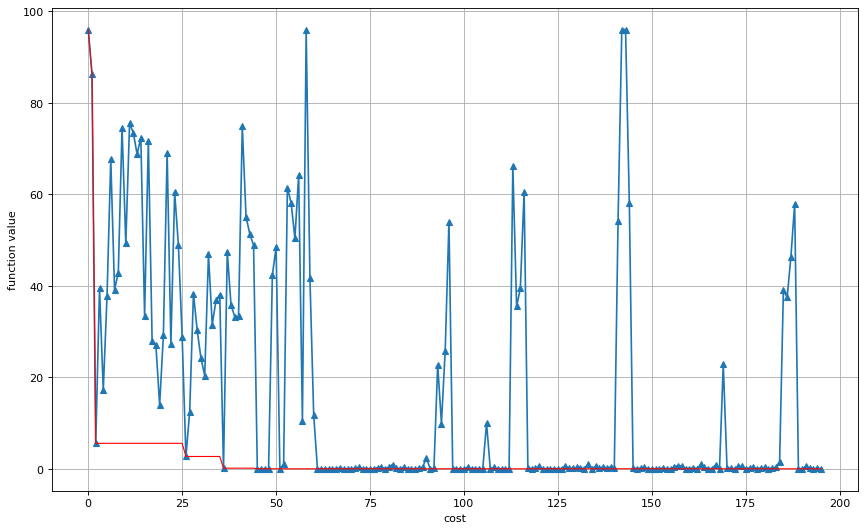

In [31]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)
pl.ylabel("function value")
pl.grid(True)

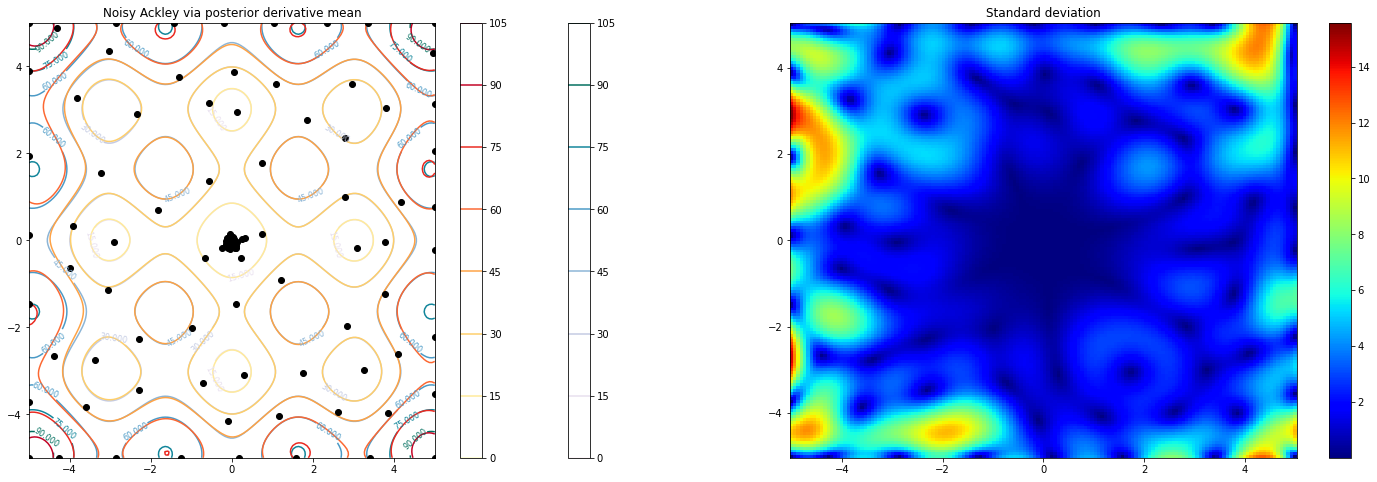

In [32]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

## Global Minima 

In [33]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([-0.0001,  0.0001]), 7.644203693503946e-07)

In [34]:
gp.get_hyper()

{'var': 55558.317562142816, 'lengthscale': 1.7053460712753812}